<h2><center>Introduction to Machine Learning: Assignment 2</center></h2>

__Given date:__ Monday September 27

__Due date:__ Friday October 15

#### Question 1 Least Absolute Shrinkage and Selection Operator 

__(13pts)__

Learning a model through the OLS loss can be done very efficiently through either gradient descent or even through the Normal equations. The same is true for ridge regression. For the Lasso formulation however, the non differentiability of the absolute value at $0$ makes the learning more tricky.



One approach, known as _ISTA_ (see Amir Beck and Marc Teboulle, _A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems_) consists in combining traditional gradient descent steps with a projection onto the $\ell_1$ norm ball. Concretely, for the LASSO objective 

\begin{align}
\ell(\boldsymbol \beta) = \|\boldsymbol X\boldsymbol \beta - \boldsymbol t\|^2_2 + \lambda \|\boldsymbol \beta\|_1
\end{align}

where $\boldsymbol \beta = (\beta_1, \beta_2,\ldots, \beta_D)$ (note that we don't include the bias) and the feature vectors $\left\{\boldsymbol  x_i\right\}_{i=1}^N$ (corresponding to the rows of the matrix $\boldsymbol X$) as well as the targets $t_i$ are assumed to be centered, i.e.
\begin{align}
\boldsymbol x_{ij} \leftarrow \boldsymbol x_{ij}-  \frac{1}{N}\sum_{i=1}^{N} x_{ij}\\
t_i \leftarrow t_i - \frac{1}{N}\sum_{i=1}^N t_i
\end{align}

(Note that this is equivalent to taking $\beta_0 = \frac{1}{N}\sum_{i=1}^N t_i$)
The ISTA update takes the form 

\begin{align}
\boldsymbol \beta^{k+1} \leftarrow \mathcal{T}_{\lambda \eta} (\boldsymbol \beta^{k} - 2\eta \mathbf{X}^T(\mathbf{X}\mathbf{\beta} - \mathbf{t}))
\end{align}

where $\mathcal{T}_{\lambda \eta}(\mathbf{x})_i$ is the thresholding operator defined component-wise as

\begin{align}
\mathcal{T}_{\lambda t}(\mathbf{\beta})_i = (|\beta_i| - \lambda t)_+ \text{sign}(\beta_i)
\end{align}

In the equations above, $\eta$ is an appropriate step size and $(x)_+ = \max(x, 0)$ 

##### Question 1.1. (5pts)

Complete the function 'ISTA' which must return a final estimate for the regression vector $\mathbf{\beta}$ given a feature matrix $\mathbf{X}$, a target vector $\mathbf{t}$ (the function should include the centering steps for $\mathbf{x}_i$ and $t_i$) regularization weight $\lambda$, and the choice for the learning rate $\eta$. 

In [1]:
def ISTA(beta_init, X, t, lbda, eta):
    
    '''The function takes as input an initial guess for beta, a set 
    of feature vectors stored in X and their corresponding 
    targets stored in t, a regularization weight lbda, 
    step size parameter eta and must return the 
    regression weights following from the minimization of 
    the LASSO objective'''
    
    beta_LASSO = np.zeros((np.shape(X)[1], 1))
    signs = np.zeros((np.shape(X)[1], 1))

    # add your code here
    sign_fxn = lambda a: -1 if a<0 else 1
    
    for i in range(1000):
        update = beta_LASSO - 2*eta*np.matmul(np.transpose(X), np.matmul(X, beta_LASSO) - t.reshape(-1, 1))
        
        for j in range(len(beta_LASSO)):
            signs[j][0] = sign_fxn(beta_LASSO[j][0])
            beta_LASSO = np.multiply((abs(update) - lbda*eta), signs)
            
    return beta_LASSO

##### Question 1.2.  (3pts)

Apply your algorithm to the data (in red) given below for polynomial features up to degree 8-10 and for various values of $\lambda$. Display the result on top of the true model (in blue).

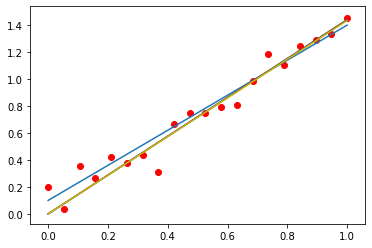

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,1,20)
xtrue = np.linspace(0,1,100)
t_true = 0.1 + 1.3*xtrue

t = 0.1 + 1.3*x
tnoisy  = t+np.random.normal(0,.1,len(x))

plt.scatter(x, tnoisy, c='r')
plt.plot(xtrue, t_true)

# add your code here
X_tilde = np.hstack((np.ones((len(x), 1)), x.reshape(-1, 1)))
beta_init = 0
X = x.reshape(-1, 1)
target = tnoisy.reshape(-1, 1)
eta = 0.01

# Trying different lambdas
lbda = 0.01
beta_LASSO_1 = ISTA(beta_init, X, target, lbda, eta)

lbda = 0.05
beta_LASSO_2 = ISTA(beta_init, X, target, lbda, eta)

lbda = 0.1
beta_LASSO_3 = ISTA(beta_init, X, target, lbda, eta)

# print(beta_LASSO_1, beta_LASSO_2, beta_LASSO_3)
prediction_1 = np.matmul(X, beta_LASSO_1)
prediction_2 = np.matmul(X, beta_LASSO_2)
prediction_3 = np.matmul(X, beta_LASSO_3)

plt.plot(x, prediction_1, c='g')
plt.plot(x, prediction_2, c='m')
plt.plot(x, prediction_3, c='y')
plt.show()

##### Question 1.3 FISTA (3pts)

It is possible to improve the ISTA updates by combining them with Nesterov accelerated gradient descent. The resulting update, known as FISTA can read, for a constant step size, by 
letting $\mathbf{y}^{(1)} = {\boldsymbol \beta}^{(0)}$, $\eta^1 = 1$ and then using 

\begin{align}
\left\{
\begin{array}{l}
&\boldsymbol{\beta}^{k} = \text{ISTA}(\mathbf{y}^{k})\\
&\eta^{(k+1)} = \frac{1+\sqrt{1+4(\eta^{(k)})^2}}{2}\\
&\mathbf{y}^{(k+1)} = {\boldsymbol\beta}^{(k)} + \left(\frac{\eta^{(k)} - 1}{\eta^{(k+1)}}\right)\left({\boldsymbol\beta}^{(k)} - {\boldsymbol\beta}^{(k-1)}\right)\end{array}\right.
\end{align}

Here $\text{ISTA}$ denotes a __single__ ISTA update.

Complete the function below so that it performs the FISTA iterations. Then apply it to the data given in question 1.2.

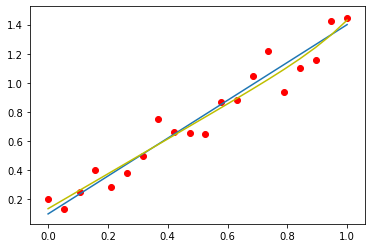

In [3]:
def FISTA(X, t, eta0, beta0, lbda):
    
    '''function should return the solution to the minimization of the
    the LASSO objective ||X*beta - t||_2^2 + lambda*||beta||_1
    by means of FISTA updates'''
    
    def single_ISTA(beta_LASSO, X, t, lbda, eta):
        # beta_LASSO -= 2*eta*np.matmul(np.transpose(X), np.matmul(X, beta_LASSO) - t.reshape(-1, 1))
        beta_LASSO -= 2*eta*np.dot(np.transpose(X), np.dot(X, beta_LASSO) - t.reshape(-1, 1))
        sign_fxn = lambda a: -1 if a<0 else 1
        for i in range(len(beta_LASSO)):
            beta_LASSO[i] = np.max((np.abs(beta_LASSO[i]) - lbda*eta), 0) * sign_fxn(beta_LASSO[i][0])
        return beta_LASSO
    
    # Declarations
    max_iter = 1000
    beta = beta0
    y = beta0
    eta = eta0
    
    for i in range(max_iter):
        beta_1 = single_ISTA(y, X, t, lbda, 0.01)
        eta_1 = (1+np.sqrt(1 + 4*eta**2))/2
        y_1 = beta_1 + (eta-1)/eta_1 * (beta_1 - beta)
        
        beta = beta_1
        eta = eta_1
        y = y_1  
    return beta
    
# Plotting results on same data as Q1.2 to check
x = np.linspace(0,1,20)
xtrue = np.linspace(0,1,100)
t_true = 0.1 + 1.3*xtrue
t = 0.1 + 1.3*x
tnoisy  = t+np.random.normal(0,.1,len(x))
plt.scatter(x, tnoisy, c='r')
plt.plot(xtrue, t_true)

# Plotting FISTA curve
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(9)
X_tilde = poly.fit_transform(x.reshape(-1, 1))

lbda = 0.05
eta = 1
beta = np.zeros((np.shape(X_tilde)[1], 1))
beta_prediction = FISTA(X_tilde, tnoisy.reshape(-1, 1), eta, beta, lbda)
prediction = np.dot(X_tilde, beta_prediction)
plt.plot(x, prediction, c='y')
plt.show()

##### Question 1.4. (2pts)

Compare the ISTA and FISTA updates by plotting the evolution of the loss $\ell(\mathbf{\beta})$ as a function of the iterations for both approaches. Take a sufficient number of iterations (1000 - 10,000)

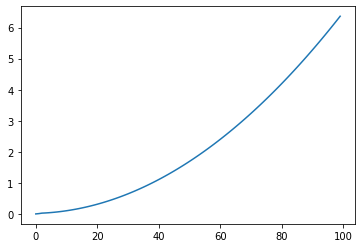

In [4]:
import matplotlib.pyplot as plt
import math

max_iter = 100
FISTA_loss = np.zeros((max_iter, 1))
ISTA_loss = np.zeros((max_iter, 1))

beta_init = 0
lbda = 0.01
eta = 0.01

FISTA_loss = []
ISTA_loss = []
for i in range(max_iter):
    x = np.linspace(0,1,i)
    X = x.reshape(-1, 1)
    t = 0.1 + 1.3*x
    # print(X)
    
    ISTA_beta_LASSO = ISTA(beta_init, X, t, lbda, eta)
    ISTA_loss_i = np.square(np.sum(np.dot(X, ISTA_beta_LASSO) -(t.reshape([-1,1])))) + lbda * np.sum(abs(ISTA_beta_LASSO))
    ISTA_loss.append(ISTA_loss_i)
    
    # FISTA_beta_LASSO = FISTA(X, t.reshape(-1,1), eta, beta, lbda) # Causes error
    # FISTA_loss_i = np.sum((np.dot(X, FISTA_beta_LASSO) - t.reshape([-1,1])) ** 2) + lbda * np.sum(abs(FISTA_beta_LASSO))
    # FISTA_loss.append(FISTA_loss_i)

# plt.plot(FISTA_loss) # Unable to plot because of unresolved error on FISTA_beta_LASSO call
plt.plot(ISTA_loss)
plt.show()

#### Question 2. Classification Trees

__(10pts)__

When the data is not easily separable, it remains possible to learn a tree based classifier. For a dataset that consists of pairs $\left\{(\mathbf{x}_i, t_i)\right\}_{i=1, \ldots, N}$ where $\mathbf{x}_i = (x_{i1}, x_{i2})\in \mathbb{R}^2$. We start with all the data in a single class. We then consider a split point $(j,s)$ such that it defines the two regions $R_1(j,s) = \left\{x|x_j\leq s\right\}$ and $R_2(j, s) = \left\{x|x_j>s\right\}$

In general we seek the splitting variables $j$ and split point $s$ that solve 
\begin{align}
\min_{j, s} \left[\min_{c_1} \sum_{\mathbf{x}_i\in R_1(j, s)} (t_i - c_1)^2 + \min_{c_2} \sum_{\mathbf{x}_i\in R_2(j, s)} (t_i - c_2)^2\right]
\end{align}

For which the inner minimization is solved by 
\begin{align}
\hat{c}_1 = \text{average}(t_i|\mathbf{x}_i \in R_1(j, s))
\end{align}
and 
\begin{align}
\hat{c}_2 = \text{average}(t_i|\mathbf{x}_i \in R_2(j, s))
\end{align}

Having found the best split, we partition the data into the corresponding two regions and repeat the splitting process on each of the two regions. Note that $s$ should always be taken amond the training points.


##### Question 2.1. (10pts)

Build a classification tree for the dataset given below with a stopping criterion corresponding to a target that is constant (or almost) across regions. Then plot the result with meshgrid and contourf. 

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Horizontal split_points:  [array([0.54550691, 0.52919708]), array([0.17453917, 0.42408759]), array([0.75979263, 0.55255474]), array([0.80587558, 0.42408759])]
Vertical split_points:  [array([0.54550691, 0.52919708]), array([0.57085253, 0.31605839]), array([0.55702765, 0.68686131]), array([0.61463134, 0.5       ])]


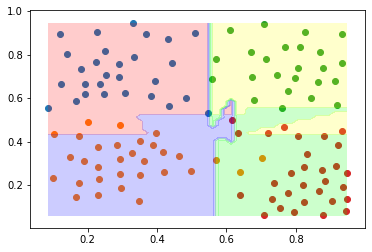

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

class1 = scipy.io.loadmat('points_Assignment2_Ex2_class1.mat')['points_Assignment2_Ex2_class1']
class2 = scipy.io.loadmat('points_Assignment2_Ex2_class2.mat')['points_Assignment2_Ex2_class2']
class3 = scipy.io.loadmat('points_Assignment2_Ex2_class3.mat')['points_Assignment2_Ex2_class3']
class4 = scipy.io.loadmat('points_Assignment2_Ex2_class4.mat')['points_Assignment2_Ex2_class4']

plt.scatter(class1[:,0], class1[:,1])
plt.scatter(class2[:,0], class2[:,1])
plt.scatter(class3[:,0], class3[:,1])
plt.scatter(class4[:,0], class4[:,1])

# add your code here
x1, targets1 = class1[:,0], class1[:,1]
x2, targets2 = class2[:,0], class2[:,1]
x3, targets3 = class3[:,0], class3[:,1]
x4, targets4 = class4[:,0], class4[:,1]

# Outputs coordinates of split point
def get_split_point(all_x, all_targets, current_class, region):
    # all_x = np.concatenate(np.array(all_x), axis=None)
    # all_targets = np.concatenate(np.array(all_targets), axis=None) 
    min_sum = 1000000 # dummy minimum inner sum; will get replaced once it enters loop
    j, s = 0, 0
    
    for i in range(len(current_class)):
        current_x = current_class[:,0][i]
        current_t = current_class[:,1][i]
        
        if region == 'top/bottom':
            c_1 = np.average(all_targets[np.where(all_targets <= current_t)])
            c_2 = np.average(all_targets[np.where(all_targets > current_t)])
            inner_sum = (current_t - c_1)**2 + (current_t - c_2)**2
        elif region == 'left/right':
            c_1 = np.average(all_x[np.where(all_x <= current_x)])
            c_2 = np.average(all_x[np.where(all_x > current_x)])
            inner_sum = (current_x - c_1)**2 + (current_x - c_2)**2
        else:
            raise ValueError
        
        if inner_sum <= min_sum:
            min_sum = inner_sum
            j = current_x
            s = current_t
        else:
            continue 
    return j, s

# Creating Class Boundaries
all_x = (x1, x2, x3, x4)
all_x = np.concatenate(np.array(all_x), axis=None)
all_targets = (targets1, targets2, targets3, targets4)
all_targets = np.concatenate(np.array(all_targets), axis=None) 
classes = (class1, class2, class3, class4)
regions = ('top/bottom', 'left/right')

h_split_points = []
v_split_points = []
for class_n in classes:
    for region in regions:
        j, s = get_split_point(all_x, all_targets, class_n, region)
        if region == 'top/bottom': h_split_points.append(np.array([j, s]))
        else: v_split_points.append(np.array([j, s]))
            
# Printing out the split points
print('Horizontal split_points: ', h_split_points)
print('Vertical split_points: ', v_split_points)

x1min, x1max = np.min(all_x), np.max(all_x)
x2min, x2max = np.min(all_targets), np.max(all_targets)

# generate set of equispaced points
x1_mesh = np.linspace(x1min, x1max, 50)
x2_mesh = np.linspace(x2min, x2max, 50)
xx1, xx2 = np.meshgrid(x1_mesh, x2_mesh)
Xprediction = np.hstack((xx1.reshape(-1,1), xx2.reshape(-1,1)))

# Helper Functions
def find_nearest(array, x, y):
    array = np.asarray(array)
    min_x, min_y = 1, 1
    min_dist = 10
    for point in array:
        dist = np.sqrt((point[0] - x)**2 + (point[1] - y)**2)
        if dist < min_dist: 
            min_dist = dist
            min_x, min_y = point[0], point[1]
    return min_x, min_y

# top left region = -2; bottom left region = -1; top right region = 2; bottom right region = 1
def predictor(h_split_points, v_split_points, Xprediction): 
    prediction_array = []
    for i in range(len(Xprediction)):
        prediction = 1
        x = Xprediction[i][0]
        y = Xprediction[i][1]
        min_hx, min_hy = find_nearest(h_split_points, x, y)
        min_vx, min_vy = find_nearest(v_split_points, x, y)
        
        if x <= min_vx:
            prediction *= -1
        if y > min_hy:
            prediction *= 2
        prediction_array.append(prediction)

    return prediction_array


# Plotting the Class Boundaries
prediction_on_grid = np.array(predictor(h_split_points, v_split_points, Xprediction))
row_len = len(x1_mesh)
prediction_on_grid = np.array(np.array_split(prediction_on_grid, row_len))

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00', '#FFFF00'])
plt.contourf(xx1, xx2, prediction_on_grid.reshape(np.shape(xx1)), levels=4, cmap = cm_bright, alpha=0.2)

# Drawing lines over split points
# for h in h_split_points:
#     plt.axhline(y=h[1], color='y', linestyle='-')
# for v in v_split_points:
#     plt.axvline(x=v[0], color='m', linestyle='-')
    
plt.show()